In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/data-portfolio
!git config --global user.email "wheelessbrian@yahoo.com"
!git config --global user.name "bwheeless7"
!mv "/content/drive/MyDrive/Colab Notebooks/03_risk_scoring_and_threshold_optimization.ipynb" fraud-risk-intelligence/notebooks

Mounted at /content/drive
/content/drive/MyDrive/data-portfolio


# Fraud Risk Scoring and Threshold Optimization

## Objective

This notebook focuses on transforming the predictive model from Notebook 2 into actionable insights:

- Generate risk scores for transactions/customers.
- Optimize the decision threshold to prioritize high-risk cases while minimizing false positives.
- Segment customers into actionable risk categories to guide interventions.

The ultimate goal is to ensure that the business can proactively identify and mitigate fraud efficiently.

# Recreate the Best Fraud Model

Since Colab runtimes are independent per notebook, we need to recreate the best-performing model from Notebook 2. This ensures that Notebook 3 is self-contained.

In [2]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
import pandas as pd

# Load the cleaned fraud transaction dataset
data = pd.read_csv("/content/drive/MyDrive/data-portfolio/fraud-risk-intelligence/data/fraud_transactions.csv")
X = data.drop("is_fraud", axis=1)
y = data["is_fraud"]

# Define numeric and categorical features
num_features = X.select_dtypes(include="number").columns
cat_features = X.select_dtypes(exclude="number").columns

# Preprocessing pipeline
preprocess = ColumnTransformer([
    ("num", StandardScaler(), num_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
])

# Recreate the best XGBoost model
best_model = XGBClassifier(
    eval_metric="logloss",
    use_label_encoder=False,
    n_estimators=200,  # best hyperparameters from Notebook 2
    max_depth=5,
    learning_rate=0.05,
    random_state=42
)

# Full pipeline
fraud_pipe = Pipeline([
    ("preprocess", preprocess),
    ("classifier", best_model)
])

# Fit the pipeline on all available data
fraud_pipe.fit(X, y)


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:16:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['transaction_id', 'customer_id', 'amount', 'hour', 'customer_age',
       'tenure_months'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['merchant_risk', 'device_type', 'country_risk'], dtype='object'))])),
                ('classifier',
                 XGBClassifier(base_score=Non...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=200, n_jobs=None,
                               num_parallel_tree=None, ...))])

# Generate Risk Scores

We calculate the probability of each transaction being fraudulent. This “risk score” allows us to rank transactions/customers by fraud likelihood.

In [3]:
# Predict probability of fraud
risk_scores = fraud_pipe.predict_proba(X)[:, 1]

# Append to the dataset
data["risk_score"] = risk_scores
data.head()

,transaction_id,customer_id,amount,merchant_risk,device_type,country_risk,hour,customer_age,tenure_months,is_fraud,risk_score
0,0,25795,147.683870,low,mobile,high,11,18,12,0,0.226826
1,1,10860,12.998237,low,pos,low,9,19,41,0,0.093157
2,2,48158,16.399346,low,web,medium,4,30,27,0,0.198379
3,3,21284,131.198953,low,pos,low,10,58,94,0,0.065184
4,4,16265,71.657540,medium,web,low,15,18,17,0,0.100681


# Optimize Decision Threshold

Rather than using the default 0.5 cutoff, we tune the threshold to prioritize detecting high-risk fraud cases while controlling false positives. The goal is to achieve a target recall for operational efficiency.

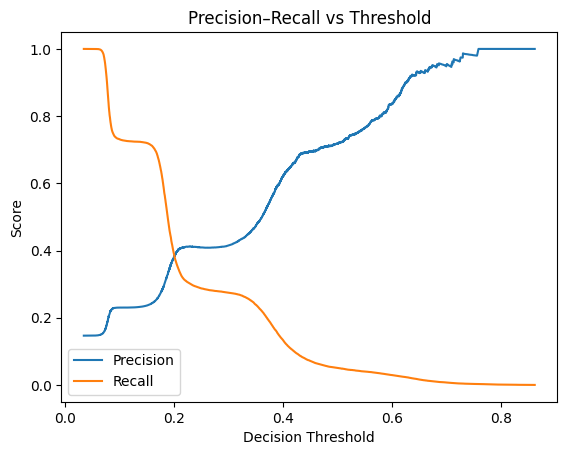

Optimal threshold: 0.08155093


In [4]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, thresholds = precision_recall_curve(y, risk_scores)

plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.xlabel("Decision Threshold")
plt.ylabel("Score")
plt.title("Precision–Recall vs Threshold")
plt.legend()
plt.show()

# Select threshold for target recall (e.g., 80%)
target_recall = 0.80
idx = (recall >= target_recall).nonzero()[0][-1]
optimal_threshold = thresholds[idx]
print("Optimal threshold:", optimal_threshold)

# Apply threshold
data["predicted_fraud"] = (risk_scores >= optimal_threshold).astype(int)

At this threshold, the model ensures that at least 80% of actual fraudulent transactions are detected. This balance minimizes missed fraud while controlling unnecessary alerts.

# Segment Customers by Risk

We categorize transactions/customers into three segments: Low, Medium, and High risk. This enables targeted interventions.

In [5]:
# Segment into Low, Medium, High risk
data["risk_segment"] = pd.qcut(data["risk_score"], 3, labels=["Low", "Medium", "High"])
data.head()

# Summary of segments
data.groupby("risk_segment")["predicted_fraud"].count()

/tmp/ipython-input-3099074621.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby("risk_segment")["predicted_fraud"].count()


,predicted_fraud
risk_segment,
Low,40000
Medium,40000
High,40000


- **High Risk:** Transactions/customers with the highest likelihood of fraud. Immediate intervention recommended.
- **Medium Risk:** Moderate likelihood. Monitor and apply selective interventions.
- **Low Risk:** Low likelihood. Standard monitoring suffices.

# Save Risk-Scored Data

We save the dataset with risk scores and segments for downstream analysis in Notebook 4.


In [6]:
data.to_csv("/content/drive/MyDrive/data-portfolio/fraud-risk-intelligence/data/fraud_risk_segmented.csv", index=False)

This file will be used in **Notebook 4: Executive Strategy & Impact** to guide decision-making and quantify the operational impact of targeted fraud interventions.